In [ ]:
import pip

In [27]:
pip.main(['install','/home/nitesh/fastText/.'])

  Using cached https://files.pythonhosted.org/packages/7b/61/11b05cc37ccdaabad89f04dbdc2a02905cf6de6f9b05816dba843beed328/numpy-1.14.3-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/67/4b/141a581104b1f6397bfa78ac9d43d8ad29a7ca43ea90a2d863fe3056e86a/six-1.11.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8c/10/79282747f9169f21c053c562a0baa21815a8c7879be97abd930dbcf862e8/setuptools-39.1.0-py2.py3-none-any.whl


You are using pip version 8.1.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


0

In [1]:
import numpy as np
import pip
import torch
from torch import nn
import fastText
import argparse
from torch.autograd import Variable
import io

In [2]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--dis_hidden_dim', type=int, default=2048, help='dimension of hidden state')
# parser.add_argument('--dis_dropout',type=float, default=0.5, help='dropout value')
# parser.add_argument('--dis_input_dropout', type=float, default=0.3, help='Point Number [default: 1024]')

# params=parser.parse_args()
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

def load_fasttext_model(path):
    """
    Load a binarized fastText model.
    """
    try:
        import fastText
    except ImportError:
        raise Exception("Unable to import fastText. Please install fastText for Python: "
                        "https://github.com/facebookresearch/fastText")
    return fastText.load_model(path)

In [3]:
# english.get
# src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
# tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

In [3]:

english=load_fasttext_model("/home/nitesh/wordembeddings/data/wiki.en.bin")
spanish=load_fasttext_model("/home/nitesh/wordembeddings/data/wiki.es.bin")
words = english.get_labels()
english_embeddings = torch.from_numpy(np.concatenate([english.get_word_vector(w)[None] for w in words], 0))
Swords = spanish.get_labels()
spanish_embeddings = torch.from_numpy(np.concatenate([spanish.get_word_vector(w)[None] for w in Swords], 0))

In [4]:
def get_batch2(X,M):
    '''
    get batch for pytorch model
    '''
    # TODO fix and make it nicer, there is pytorch forum question
    #X,Y = X.data.numpy(), Y.data.numpy()
#     X,Y = X, Y
    N = X.size()[0]
    N=200000
    batch_indices = torch.LongTensor( np.random.randint(0,N,size=M) )
#     print(batch_indices)
    batch_xs = torch.index_select(X,0,batch_indices)
#     batch_ys = torch.index_select(Y,0,batch_indices)
    return Variable(batch_xs, requires_grad=False).cuda()

In [5]:
class Discriminator(nn.Module):

    def __init__(self, dis_hid_dim,dis_dropout,dis_input_dropout):
        super(Discriminator, self).__init__()

        self.emb_dim = 300
        self.dis_layers = 3
        self.dis_hid_dim = dis_hid_dim
        self.dis_dropout = dis_dropout
        self.dis_input_dropout = dis_input_dropout

        layers = [nn.Dropout(self.dis_input_dropout)]
        for i in range(self.dis_layers + 1):
            input_dim = self.emb_dim if i == 0 else self.dis_hid_dim
            output_dim = 1 if i == self.dis_layers else self.dis_hid_dim
            layers.append(nn.Linear(input_dim, output_dim))
            if i < self.dis_layers:
                layers.append(nn.LeakyReLU(0.2))
                layers.append(nn.Dropout(self.dis_dropout))
        layers.append(nn.Sigmoid())
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        assert x.dim() == 2 and x.size(1) == self.emb_dim
        return self.layers(x).view(-1)

In [6]:

def Orthogonal(mapping,beta):
    W=mapping.weight.data
#     print(type(W))
  
    mapping.weight.data.copy_((1 + beta) * W - beta * W.mm(W.transpose(0, 1).mm(W)))
#     print(mapping.weight.data.transpose(0, 1).mm(W))
    
    return mapping


In [7]:
#set up linear mapping,
mapping = nn.Linear(300, 300, bias=False)
mapping.weight.data.copy_(torch.eye(300))
modelDisc= Discriminator(2048,0.3,0.1)
mapping.cuda()
modelDisc.cuda()

Discriminator(
  (layers): Sequential(
    (0): Dropout(p=0.1)
    (1): Linear(in_features=300, out_features=2048, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3)
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Dropout(p=0.3)
    (7): Linear(in_features=2048, out_features=2048, bias=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Dropout(p=0.3)
    (10): Linear(in_features=2048, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

In [8]:
linoptimizer = torch.optim.SGD(mapping.parameters(), lr=0.1)
discoptimizer= torch.optim.SGD(modelDisc.parameters(), lr=0.1)
# torch.optim.
loss_fn=torch.nn.BCELoss()

In [30]:
epoch=10000
batch_size=16
# E_batch=Batch(english_embeddings)
# S_batch=Batch(spanish_embeddings)
dog=Variable(english_embeddings[english.get_word_id('the')]).cuda()

perro=spanish_embeddings[spanish.get_word_id('el')]
for _ in range(epoch):
      
    
    modelDisc.train()
    mapping.eval()
    for __ in range(5):
        
        #get minibatch of spanish words
        spanish_batch=get_batch2(spanish_embeddings,batch_size)
        #getminibatch of english words
        english_batch=get_batch2(english_embeddings,batch_size)
        
        #generate fake spanish embeddings
        s_fake= mapping(english_batch)
        
        #stack real and fake
        x = torch.cat([spanish_batch, s_fake], 0)
#         print(x.shape)
        y = torch.FloatTensor(2 * batch_size).zero_().cuda()
        
        y[batch_size:] = 0.1
        y[:batch_size]=1-0.1
        y_pred = modelDisc(x)
#         print(y_pred.shape)
        # Compute and print loss.
        

        loss= loss_fn(y_pred, y)
#         print(y_pred[0])
        discoptimizer.zero_grad()
       
        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()
#         print(loss.data)

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        discoptimizer.step()
        
        
    for __ in range(1):
        modelDisc.eval()
        mapping.train()
        spanish_batch=get_batch2(spanish_embeddings,batch_size)
        #getminibatch of english words
        english_batch=get_batch2(english_embeddings,batch_size)
        
        #generate fake spanish embeddings
        s_fake= mapping(english_batch)
        
        #stack real and fake
        x = torch.cat([spanish_batch, s_fake], 0)
#         print(x.shape)
        y = torch.FloatTensor(2 * batch_size).zero_().cuda()
        
        y[batch_size:] = 1-0.1
        y[:batch_size]=0.1
        y_pred = modelDisc(x)
        loss2= loss_fn(y_pred, y)
        linoptimizer.zero_grad()
        loss2.backward()
        linoptimizer.step()
        
        if _%1:
            mapping=Orthogonal(mapping,0.001)
        cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    #     print(type(perro),type(mapping(dog).cpu()))
    print(cos(perro.cpu(),mapping(dog).cpu()))
    
    
    

tensor(0.3078)
tensor(0.3093)
tensor(0.3089)
tensor(0.3084)
tensor(0.3089)
tensor(0.3085)
tensor(0.3109)
tensor(0.3092)
tensor(0.3118)
tensor(0.3138)
tensor(0.3157)
tensor(0.3182)
tensor(0.3197)
tensor(0.3213)
tensor(0.3241)
tensor(0.3241)
tensor(0.3186)
tensor(0.3194)
tensor(0.3170)
tensor(0.3160)
tensor(0.3124)
tensor(0.3079)
tensor(0.3057)
tensor(0.3038)
tensor(0.3019)
tensor(0.3020)
tensor(0.3027)
tensor(0.3063)
tensor(0.3099)
tensor(0.3162)
tensor(0.3160)
tensor(0.3134)
tensor(0.3110)
tensor(0.3125)
tensor(0.3151)
tensor(0.3166)
tensor(0.3146)
tensor(0.3143)
tensor(0.3079)
tensor(0.3065)
tensor(0.3057)
tensor(0.3072)
tensor(0.3059)
tensor(0.3035)
tensor(0.3061)
tensor(0.3072)
tensor(0.3077)
tensor(0.3117)
tensor(0.3153)
tensor(0.3156)
tensor(0.3134)
tensor(0.3120)
tensor(0.3033)
tensor(0.3032)
tensor(0.3024)
tensor(0.3037)
tensor(0.3013)
tensor(0.3023)
tensor(0.3031)
tensor(0.2995)
tensor(0.2993)
tensor(0.2994)
tensor(0.3025)
tensor(0.3057)
tensor(0.3047)
tensor(0.3012)
tensor(0.3

tensor(0.3203)
tensor(0.3183)
tensor(0.3178)
tensor(0.3174)
tensor(0.3134)
tensor(0.3117)
tensor(0.3064)
tensor(0.3101)
tensor(0.3067)
tensor(0.3026)
tensor(0.3001)
tensor(0.2977)
tensor(0.2956)
tensor(0.2968)
tensor(0.2969)
tensor(0.2932)
tensor(0.2972)
tensor(0.2968)
tensor(0.2962)
tensor(0.3007)
tensor(0.3085)
tensor(0.3108)
tensor(0.3092)
tensor(0.3090)
tensor(0.3036)
tensor(0.3034)
tensor(0.3112)
tensor(0.3125)
tensor(0.3132)
tensor(0.3124)
tensor(0.3151)
tensor(0.3123)
tensor(0.3158)
tensor(0.3160)
tensor(0.3144)
tensor(0.3159)
tensor(0.3135)
tensor(0.3088)
tensor(0.3055)
tensor(0.3080)
tensor(0.3112)
tensor(0.3132)
tensor(0.3109)
tensor(0.3142)
tensor(0.3140)
tensor(0.3145)
tensor(0.3137)
tensor(0.3094)
tensor(0.3110)
tensor(0.3167)
tensor(0.3203)
tensor(0.3182)
tensor(0.3199)
tensor(0.3233)
tensor(0.3213)
tensor(0.3239)
tensor(0.3233)
tensor(0.3243)
tensor(0.3194)
tensor(0.3173)
tensor(0.3152)
tensor(0.3114)
tensor(0.3077)
tensor(0.3049)
tensor(0.3041)
tensor(0.3052)
tensor(0.3

KeyboardInterrupt: 

In [10]:
# spanish_embeddings
tgt_emd=spanish_embeddings.numpy()
# print(tgt_emd.shape)


def get_nn(word_emb, tgt_emb, tgt_id2word, K=5):
  
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [11]:
def create_map(words,language):
    id2word={}
    for word in words:
        id=language.get_word_id(word)
        id2word[id]=word
    return id2word
spanish_map=create_map(Swords,spanish)
        

In [12]:
cat_embedding=mapping(Variable(english_embeddings[english.get_word_id('dog')],requires_grad=False).cuda()).cpu()
word_emd=cat_embedding.detach().numpy()
get_nn(word_emd,tgt_emd,spanish_map)


0.5148 - virman
0.5144 - tiê
0.5080 - keeani
0.5075 - tongolele
0.5024 - luongo


In [13]:
src_embeddings=mapping(Variable(english_embeddings, requires_grad=False).cuda())


In [15]:
src_embedding=src_embeddings.cpu().detach().numpy()
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embedding, spanish_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.09


In [19]:
import matplotlib.pyplot as plt


def plot_similar_word(src_words, src, src_emb, tgt_words, tgt, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src.get_word_id(sw)])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt.get_word_id(tw)])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()
    

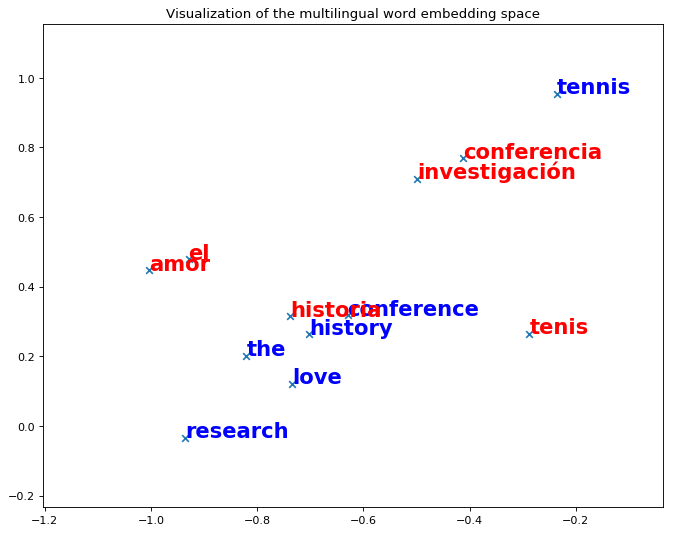

In [29]:
src_words = ['the', 'love', 'history', 'tennis', 'research', 'conference']
tgt_words = ['el', 'amor', 'historia', u'tenis',  u'investigación', 'conferencia']

plot_similar_word(src_words,english,english_embeddings.cpu().detach().numpy(),tgt_words,spanish,spanish_embeddings.cpu().detach().numpy(),pca)
# english.get_word_id

In [23]:
type(spanish_embeddings)

torch.Tensor